In [ ]:
import os
from google.colab import drive

drive.mount("/content/MyDrive")

Mounted at /content/MyDrive


In [2]:
!pip install resampy
!pip install librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.1 MB/s eta 0:00:00


##Importing Libraries

In [7]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from tensorflow import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers
from keras import optimizers
import pandas as pd
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.preprocessing import LabelEncoder
import joblib

In [ ]:
emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

feelings = []
audio = []

for k in range(1,10):
    c = os.listdir(f"/content/MyDrive/MyDrive/audio_speech_actors_01-24/Actor_0{k}")
    audio.extend(c)
    gen = "female" if k % 2 == 0 else "male"
    for i in c:
        em = i.split("-")[2]
        feelings.append(f"{gen}_{emotion_mapping[em]}")

for k in range(10,25):
    c = os.listdir(f"/content/MyDrive/MyDrive/audio_speech_actors_01-24/Actor_{k}")
    audio.extend(c)
    gen = "female" if k % 2 == 0 else "male"
    for i in c:
        em = i.split("-")[2]
        feelings.append(f"{gen}_{emotion_mapping[em]}")

In [ ]:
feelings

['male_angry',
 'male_fearful',
 'male_sad',
 'male_calm',
 'male_neutral',
 'male_fearful',
 'male_neutral',
 'male_neutral',
 'male_fearful',
 'male_sad',
 'male_fearful',
 'male_sad',
 'male_happy',
 'male_angry',
 'male_sad',
 'male_sad',
 'male_happy',
 'male_neutral',
 'male_calm',
 'male_sad',
 'male_calm',
 'male_calm',
 'male_calm',
 'male_angry',
 'male_calm',
 'male_angry',
 'male_happy',
 'male_happy',
 'male_sad',
 'male_happy',
 'male_happy',
 'male_angry',
 'male_happy',
 'male_angry',
 'male_calm',
 'male_sad',
 'male_happy',
 'male_angry',
 'male_angry',
 'male_calm',
 'male_surprised',
 'male_fearful',
 'male_surprised',
 'male_surprised',
 'male_surprised',
 'male_fearful',
 'male_surprised',
 'male_disgust',
 'male_surprised',
 'male_disgust',
 'male_disgust',
 'male_disgust',
 'male_disgust',
 'male_fearful',
 'male_disgust',
 'male_disgust',
 'male_surprised',
 'male_surprised',
 'male_disgust',
 'male_fearful',
 'female_sad',
 'female_neutral',
 'female_sad',
 'f

## Plotting the audio file's waveform and its spectrogram

In [ ]:
data, sampling_rate = librosa.load('/content/MyDrive/MyDrive/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav')

In [ ]:
sampling_rate

22050

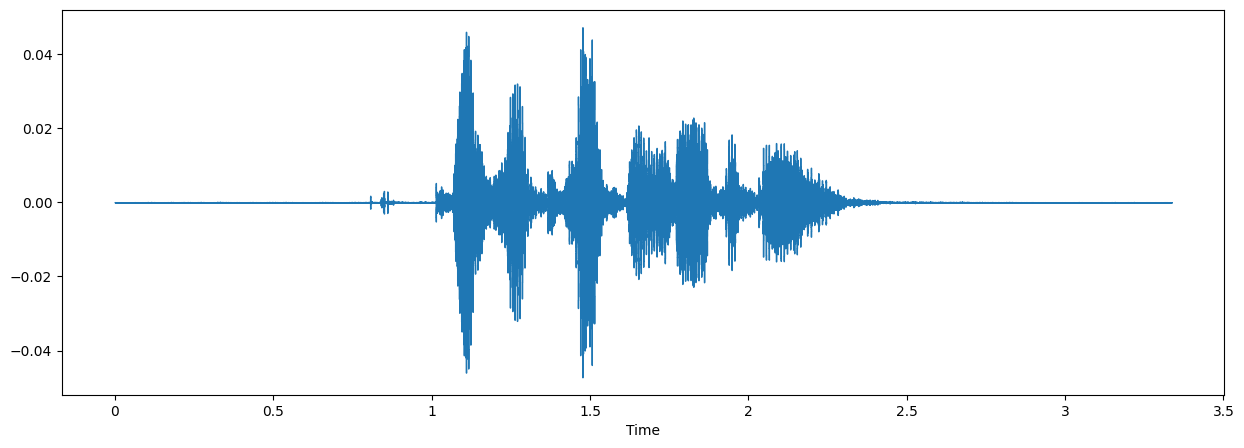

In [ ]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

<ipython-input-9-611825e5c6f4>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('/content/MyDrive/MyDrive/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav')
<ipython-input-9-611825e5c6f4>:26: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


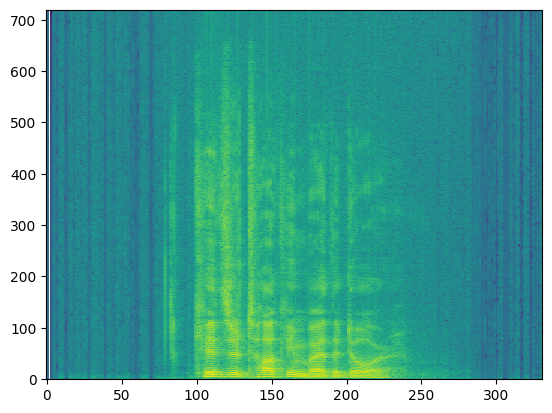

In [ ]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('/content/MyDrive/MyDrive/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhance its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.

In [3]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=4)


In [ ]:
path = '/content/MyDrive/MyDrive/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav'
data, sample_rate = librosa.load(path)

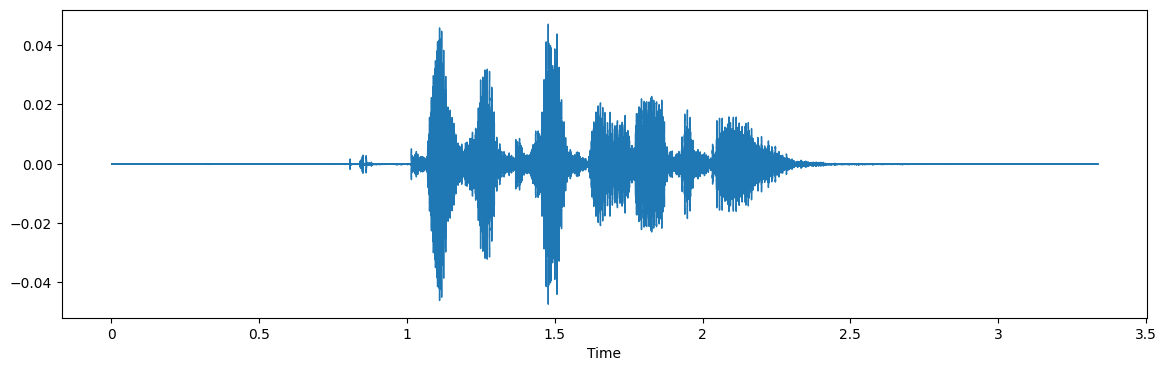

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

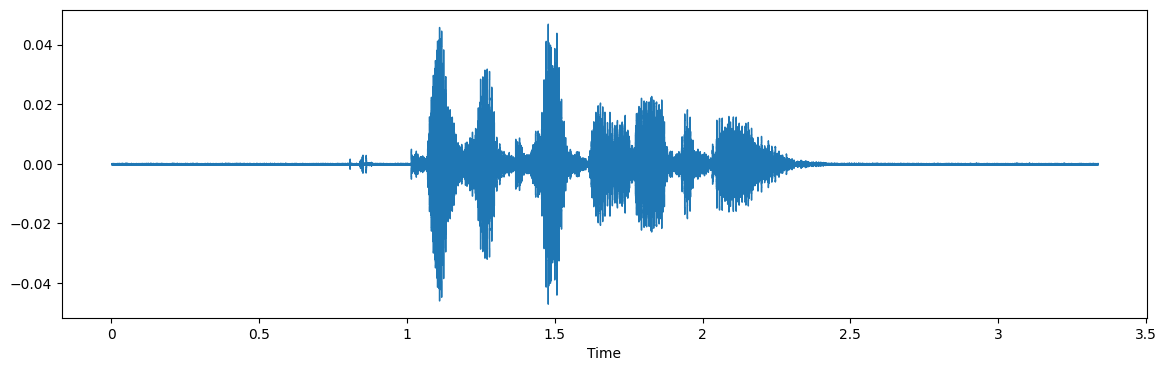

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(path)

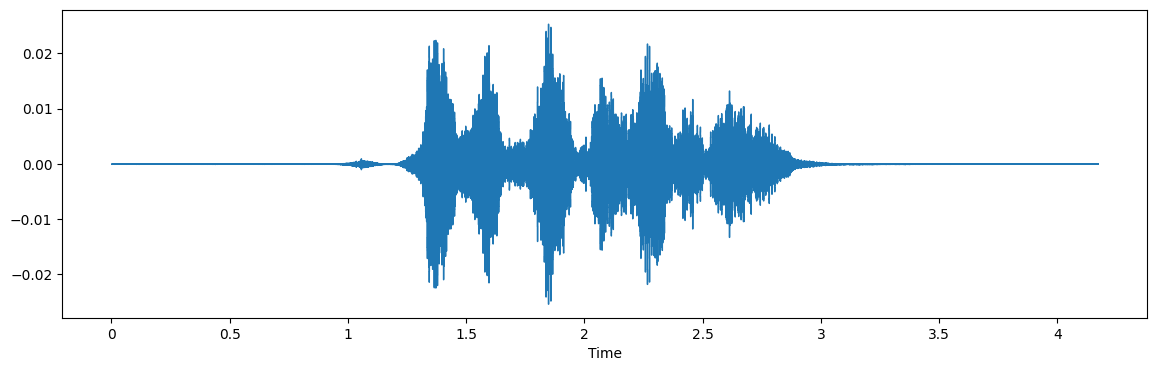

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

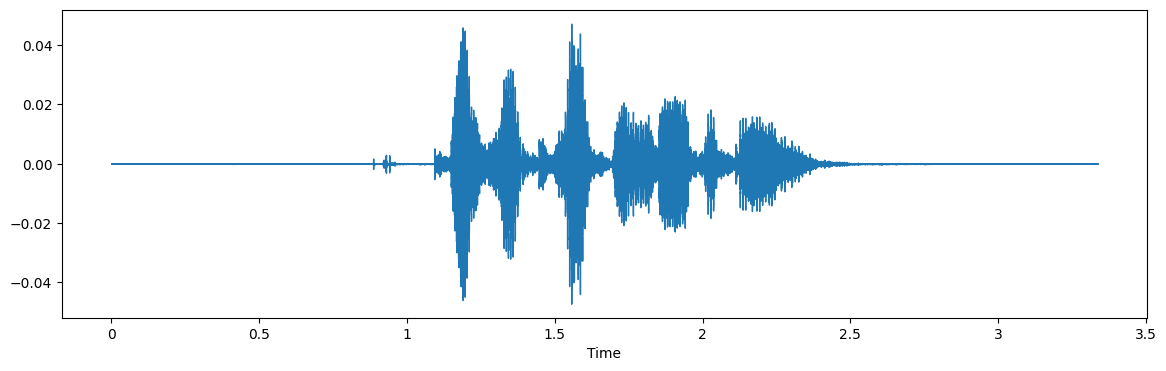

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

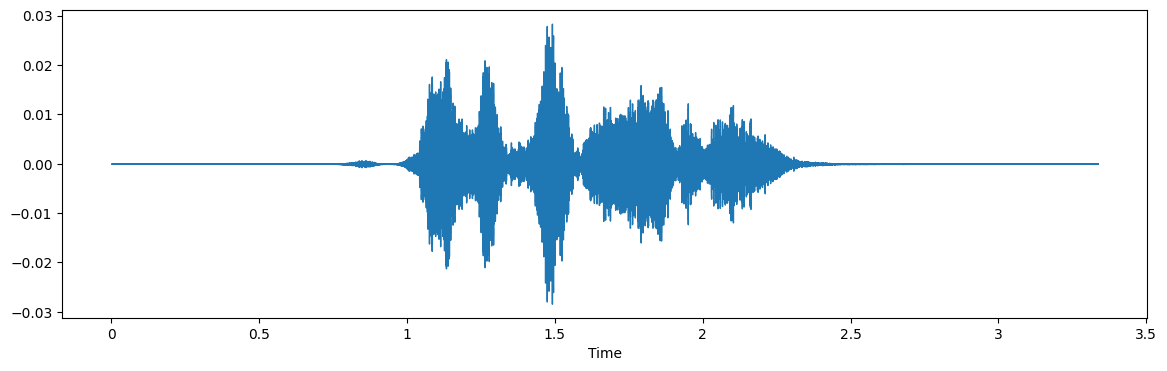

In [ ]:
x = pitch(data, sampling_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I referenced an excellent blog on audio signal feature extraction and clustering written by Akash Mallik, which can be found on Medium : [Audio signal feature extraction and clustering](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225)


As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [14]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
for aud, label in zip(audio,feelings):
    ac = aud.split("-")[-1].split(".")[0]
    feature = get_features(f'/content/MyDrive/MyDrive/audio_speech_actors_01-24/Actor_{ac}'+'/'+ aud)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(label)

In [ ]:
Y[:5]

['male_angry', 'male_angry', 'male_angry', 'male_fearful', 'male_fearful']

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.215391,0.595330,0.642112,0.661036,0.712141,0.662088,0.631221,0.616520,0.589835,0.601767,...,0.000170,0.000141,0.000151,0.000182,0.000150,0.000164,0.000256,0.000182,0.000010,male_angry
1,0.324427,0.746074,0.781724,0.805257,0.847615,0.798806,0.719482,0.675454,0.666352,0.690680,...,0.002168,0.002213,0.002200,0.002201,0.002113,0.002283,0.002275,0.002226,0.002053,male_angry
2,0.208757,0.578640,0.673512,0.668285,0.580192,0.595913,0.612214,0.611553,0.690745,0.648997,...,0.000261,0.000206,0.000217,0.000136,0.000061,0.000057,0.000048,0.000022,0.000001,male_angry
3,0.184706,0.720850,0.682144,0.653873,0.654023,0.587913,0.556389,0.658182,0.702822,0.640918,...,0.000064,0.000051,0.000074,0.000129,0.000197,0.000248,0.000247,0.000163,0.000012,male_fearful
4,0.203948,0.760535,0.720841,0.704644,0.703978,0.656901,0.601444,0.662694,0.701972,0.639817,...,0.000066,0.000052,0.000076,0.000132,0.000201,0.000251,0.000249,0.000164,0.000014,male_fearful


* We have applied data augmentation and extracted the features for each audio files and saved them.

In [27]:
Features = pd.read_csv("/content/features.csv")

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [28]:
from sklearn.utils import shuffle
rnewdf = shuffle(Features)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
2522,0.144969,0.512007,0.594714,0.598016,0.613853,0.612993,0.591652,0.607009,0.642822,0.619760,...,0.000034,0.000032,0.000020,0.000024,0.000034,0.000030,0.000030,0.000011,7.304553e-07,male_calm
3594,0.323346,0.687636,0.693466,0.667570,0.692865,0.683293,0.642710,0.638290,0.684345,0.649865,...,0.000019,0.000017,0.000018,0.000019,0.000016,0.000019,0.000025,0.000015,1.636484e-06,female_surprised
2494,0.279903,0.660241,0.637855,0.641112,0.696163,0.679659,0.688057,0.656448,0.601218,0.603976,...,0.000111,0.000106,0.000064,0.000435,0.000153,0.000040,0.000036,0.000033,2.858614e-06,female_neutral
2917,0.317238,0.774353,0.794202,0.819200,0.788430,0.805445,0.769700,0.701892,0.714847,0.707190,...,0.000592,0.000594,0.000603,0.000631,0.000587,0.000619,0.000599,0.000630,5.702641e-04,male_sad
2979,0.135023,0.670393,0.714880,0.642344,0.659974,0.659175,0.655079,0.659058,0.716214,0.727029,...,0.000039,0.000064,0.000041,0.000049,0.000078,0.000063,0.000057,0.000050,4.938787e-06,male_disgust
3973,0.344654,0.747102,0.758782,0.775454,0.836289,0.831229,0.712055,0.749901,0.765989,0.733718,...,0.004202,0.003585,0.003154,0.003487,0.004090,0.004095,0.003512,0.002619,1.473050e-03,male_disgust
1277,0.132509,0.598727,0.663654,0.601181,0.520503,0.513087,0.587952,0.709462,0.621351,0.447479,...,0.000043,0.000040,0.000024,0.000022,0.000026,0.000028,0.000032,0.000014,1.350791e-06,female_fearful
2397,0.358050,0.780974,0.693594,0.634154,0.640962,0.581806,0.567735,0.617817,0.654093,0.637337,...,0.000329,0.000288,0.000311,0.000335,0.000345,0.000258,0.000201,0.000091,9.694409e-06,female_fearful
3571,0.279903,0.766840,0.714062,0.691480,0.684328,0.681404,0.624426,0.564149,0.548786,0.541039,...,0.000337,0.000403,0.000468,0.000513,0.000326,0.000365,0.000290,0.000242,6.558768e-05,female_disgust
3232,0.295600,0.563519,0.535466,0.563170,0.643569,0.729370,0.714139,0.649093,0.580888,0.570631,...,0.003984,0.004423,0.004513,0.003922,0.003499,0.003857,0.003454,0.002900,2.566975e-03,female_sad


In [29]:
X = rnewdf.iloc[: ,:-1].values
Y = rnewdf['labels'].values

In [30]:
X.shape

(4320, 162)

In [ ]:
from google.colab import files

files.download('features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [32]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 16), (1080, 162), (1080, 16))

In [33]:
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 16), (1080, 162), (1080, 16))

In [ ]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)

In [ ]:
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((3240, 162, 1), (3240, 16), (1080, 162, 1), (1080, 16))

## Modelling

In [ ]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(162,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(64, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(64, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(32, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(16))
model.add(Activation('softmax'))

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.00003,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)
opt = keras.optimizers.RMSprop(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 activation (Activation)     (None, 162, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 162, 128)          163968    
                                                                 
 activation_1 (Activation)   (None, 162, 128)          0         
                                                                 
 dropout (Dropout)           (None, 162, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 128)           0         
 D)                                                              
                                                        

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=64, epochs=500, validation_data=(x_testcnn, y_test))

Epoch 1/500
51/51 [==============================] - 20s 359ms/step - loss: 2.9815 - accuracy: 0.0731 - val_loss: 2.7944 - val_accuracy: 0.0880
Epoch 2/500
51/51 [==============================] - 18s 360ms/step - loss: 2.8034 - accuracy: 0.0997 - val_loss: 2.7421 - val_accuracy: 0.1185
Epoch 3/500
51/51 [==============================] - 19s 367ms/step - loss: 2.7564 - accuracy: 0.1123 - val_loss: 2.7399 - val_accuracy: 0.1204
Epoch 4/500
51/51 [==============================] - 18s 345ms/step - loss: 2.6959 - accuracy: 0.1262 - val_loss: 2.7052 - val_accuracy: 0.1324
Epoch 5/500
51/51 [==============================] - 18s 345ms/step - loss: 2.6835 - accuracy: 0.1336 - val_loss: 2.6795 - val_accuracy: 0.1463
Epoch 6/500
51/51 [==============================] - 18s 346ms/step - loss: 2.7002 - accuracy: 0.1503 - val_loss: 2.6688 - val_accuracy: 0.1556
Epoch 7/500
51/51 [==============================] - 18s 348ms/step - loss: 2.6571 - accuracy: 0.1552 - val_loss: 2.6519 - val_accuracy:

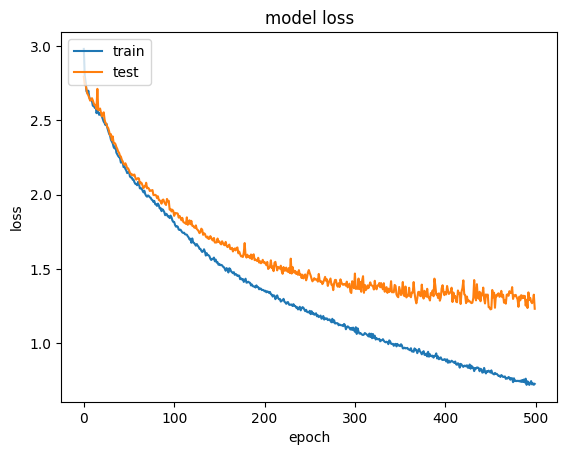

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_path = '/content/models/Emotion_Voice_Detection_Model.h5'
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.00004,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)
opt = keras.optimizers.RMSprop(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=64, epochs=20, validation_data=(x_testcnn, y_test))

Epoch 1/20
51/51 [==============================] - 19s 349ms/step - loss: 0.5606 - accuracy: 0.8111 - val_loss: 1.3212 - val_accuracy: 0.6370
Epoch 2/20
51/51 [==============================] - 17s 344ms/step - loss: 0.5456 - accuracy: 0.8077 - val_loss: 1.2376 - val_accuracy: 0.6519
Epoch 3/20
51/51 [==============================] - 17s 344ms/step - loss: 0.5410 - accuracy: 0.8133 - val_loss: 1.3308 - val_accuracy: 0.6500
Epoch 4/20
51/51 [==============================] - 18s 364ms/step - loss: 0.5367 - accuracy: 0.8244 - val_loss: 1.2699 - val_accuracy: 0.6491
Epoch 5/20
51/51 [==============================] - 19s 363ms/step - loss: 0.5321 - accuracy: 0.8219 - val_loss: 1.2670 - val_accuracy: 0.6537
Epoch 6/20
51/51 [==============================] - 19s 372ms/step - loss: 0.5324 - accuracy: 0.8213 - val_loss: 1.2135 - val_accuracy: 0.6481
Epoch 7/20
51/51 [==============================] - 18s 346ms/step - loss: 0.5530 - accuracy: 0.8120 - val_loss: 1.2657 - val_accuracy: 0.6472

In [ ]:
model_path = '/content/models/Emotion_Voice_Detection_Model_final2.keras'
model.save(model_path)

In [9]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/Emotion_Voice_Detection_Model_final2.keras')

In [ ]:
score = model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 66.39%


## Predicting emotions on the test data

In [ ]:
preds = model.predict(x_testcnn,
                         batch_size=32,
                         verbose=1)

34/34 [==============================] - 2s 39ms/step


In [ ]:
preds.shape

(1080, 16)

In [ ]:
pred_labels = np.argmax(preds, axis=1)

original_labels = encoder.categories_[0]

# Map the class indices to the original labels
predicted_labels = original_labels[pred_labels]

In [ ]:
print("Predicted labels: ", predicted_labels)

Predicted labels:  ['male_surprised' 'female_happy' 'female_neutral' ... 'male_happy'
 'male_happy' 'male_surprised']


In [ ]:
preddf = pd.DataFrame({'predictedvalues': predicted_labels})
preddf[:10]

,predictedvalues
0,male_surprised
1,female_happy
2,female_neutral
3,female_calm
4,male_sad
5,male_calm
6,female_neutral
7,female_neutral
8,female_disgust
9,female_neutral


In [ ]:
actual_labels_indices = y_test.argmax(axis=1)
actual_labels = original_labels[actual_labels_indices]
actualdf = pd.DataFrame({'actualvalues': actual_labels})
actualdf[:10]

,actualvalues
0,male_surprised
1,female_happy
2,female_neutral
3,female_happy
4,male_happy
5,male_sad
6,female_happy
7,female_angry
8,female_disgust
9,female_neutral


In [ ]:
finaldf = actualdf.join(preddf)

In [ ]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_calm,female_calm
171,male_disgust,male_disgust
172,male_surprised,male_surprised
173,female_surprised,female_surprised
174,female_calm,female_calm
175,male_surprised,male_surprised
176,female_disgust,female_disgust
177,male_angry,male_angry
178,female_happy,female_happy
179,female_surprised,female_surprised


In [ ]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,67
female_calm,69
female_disgust,78
female_fearful,80
female_happy,70
female_neutral,28
female_sad,71
female_surprised,75
male_angry,72


In [ ]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,75
female_calm,66
female_disgust,63
female_fearful,66
female_happy,75
female_neutral,29
female_sad,76
female_surprised,90
male_angry,53


In [ ]:
folder_name = 'preprocessing_objects'

# Create the folder if it doesn't exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Save the OneHotEncoder
joblib.dump(encoder, os.path.join(folder_name, 'onehot_encoder.pkl'))

# Save the RobustScaler
joblib.dump(scaler, os.path.join(folder_name, 'robust_scaler.pkl'))

['preprocessing_objects/robust_scaler.pkl']

In [ ]:
folder_name = 'preprocessing_objects'

# Load the OneHotEncoder
encoder = joblib.load(os.path.join(folder_name, 'onehot_encoder.pkl'))

# Load the RobustScaler
scaler = joblib.load(os.path.join(folder_name, 'robust_scaler.pkl'))

## Live Demo

#### The file 'output10.wav' in the following cell is the file that was recorded live


In [10]:
def predict_label(file_path):
    # Extract features from the new audio file
    features = get_features(file_path)

    # Aggregate the features for prediction
    features_aggregated = np.mean(features, axis=0)

    # Standardize the features
    features_aggregated = scaler.transform([features_aggregated])

    # Reshape to fit the model input
    features_aggregated = np.expand_dims(features_aggregated, axis=2)

    # Make prediction
    preds = model.predict(features_aggregated, verbose=1)

    # Convert prediction to class index
    pred_label_index = np.argmax(preds, axis=1)

    # Convert class index to original label
    original_labels = encoder.categories_[0]
    predicted_label = original_labels[pred_label_index]

    return predicted_label[0]

In [42]:
path = '/content/output10.wav'

In [43]:
Audio(path)

In [ ]:
predicted_label = predict_label(path)
print("Predicted label: ", predicted_label)

1/1 [==============================] - 0s 35ms/step
Predicted label:  male_disgust
